In [139]:
###           Written and Executed By:            ####
###               Sheekar Banerjee                ####
###        Senior Software Engineer- AI & ML      ####

# Breast Cancer Detection
# Ultrasound Image
# Efficient-Net-B7 (EfficientNetB7)
# Accuracy 99.00 %

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small, MobileNet, InceptionV3
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
dir_path = '/content/drive/MyDrive/breast ultra'
IMAGE_SHAPE = (224, 224)

In [142]:
# create prepare_image method
# used to preprocess the image for efficientNet model
def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

In [143]:
directories = os.listdir(dir_path) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(dir_path + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)
    
len(files), len(labels)

(1578, 1578)

In [144]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(780, 780)

In [145]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [], 
    'target': []
}

print('Preparing the image...')

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Preparing the image...
Finished.


In [146]:
# convert lists to arrays 
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


In [147]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((702, 224, 224, 3), (78, 224, 224, 3), (702,), (78,))

In [148]:
#Build Model

from keras.applications.efficientnet import EfficientNetB7

base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

incept_model.summary()


258088960/258076736 [==============================] - 4s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 224, 224, 3)  0           ['input_9[0][0]']                
                                                                                                  
 normalization_8 (Normalization  (None, 224, 224, 3)  7          ['rescaling_8[0][0]']            
 )                                                                                                
                         

In [149]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='breast_Neurals_sheekar.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model]) 

Epoch 1/100
22/22 [==============================] - 41s 793ms/step - loss: 0.9979 - sparse_categorical_accuracy: 0.5698 - val_loss: 0.9506 - val_sparse_categorical_accuracy: 0.6538
Epoch 2/100
22/22 [==============================] - 11s 524ms/step - loss: 0.6891 - sparse_categorical_accuracy: 0.7336 - val_loss: 0.9436 - val_sparse_categorical_accuracy: 0.6923
Epoch 3/100
22/22 [==============================] - 12s 565ms/step - loss: 0.5502 - sparse_categorical_accuracy: 0.7949 - val_loss: 0.8366 - val_sparse_categorical_accuracy: 0.7564
Epoch 4/100
22/22 [==============================] - 11s 501ms/step - loss: 0.4967 - sparse_categorical_accuracy: 0.8063 - val_loss: 0.7436 - val_sparse_categorical_accuracy: 0.7564
Epoch 5/100
22/22 [==============================] - 11s 503ms/step - loss: 0.4272 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.7116 - val_sparse_categorical_accuracy: 0.6795
Epoch 6/100
22/22 [==============================] - 9s 422ms/step - loss: 0.3707 - sparse

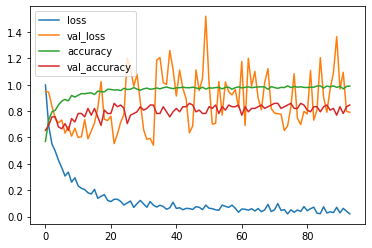

In [150]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [151]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

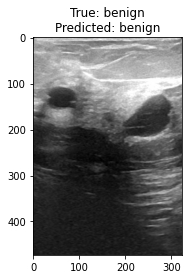

In [152]:
predict_image('/content/drive/MyDrive/breast ultra/benign/benign (100).png', 'benign')

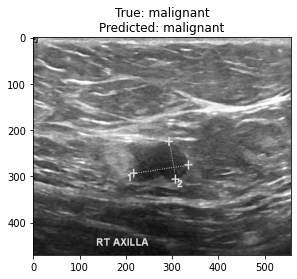

In [153]:
predict_image('/content/drive/MyDrive/breast ultra/malignant/malignant (110).png', 'malignant')

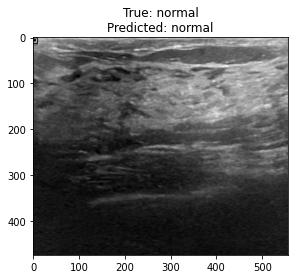

In [154]:
predict_image('/content/drive/MyDrive/breast ultra/normal/normal (109).png', 'normal')